In [85]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.5.7/spark-3.5.7-bin-hadoop3.tgz
!tar xf spark-3.5.7-bin-hadoop3.tgz
!pip install -q findspark

In [86]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [87]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.7-bin-hadoop3"

In [88]:
!ls

cars.csv     spark-3.5.7-bin-hadoop3	  spark-3.5.7-bin-hadoop3.tgz.1
sample_data  spark-3.5.7-bin-hadoop3.tgz


In [89]:
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) 
spark

In [90]:
# from google.colab import drive  # type: ignore
# drive.mount('/content/drive')

In [91]:
!wget https://jacobceles.github.io/knowledge_repo/colab_and_pyspark/cars.csv

--2025-11-17 05:20:15--  https://jacobceles.github.io/knowledge_repo/colab_and_pyspark/cars.csv
Resolving jacobceles.github.io (jacobceles.github.io)... 185.199.110.153, 185.199.108.153, 185.199.111.153, ...
Connecting to jacobceles.github.io (jacobceles.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://jacobcelestine.com/knowledge_repo/colab_and_pyspark/cars.csv [following]
--2025-11-17 05:20:15--  https://jacobcelestine.com/knowledge_repo/colab_and_pyspark/cars.csv
Resolving jacobcelestine.com (jacobcelestine.com)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to jacobcelestine.com (jacobcelestine.com)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22608 (22K) [text/csv]
Saving to: ‘cars.csv.1’

cars.csv.1          100%[===================>]  22.08K  --.-KB/s    in 0.001s  

2025-11-17 05:20:15 (19.2 MB/s) - ‘cars.csv.1’ saved [22608/22608]



In [92]:
df = spark.read.csv('cars.csv', header=True, sep=";", inferSchema=True)
df.show(5)

+--------------------+----+---------+------------+----------+------+------------+-----+------+
|                 Car| MPG|Cylinders|Displacement|Horsepower|Weight|Acceleration|Model|Origin|
+--------------------+----+---------+------------+----------+------+------------+-----+------+
|Chevrolet Chevell...|18.0|        8|       307.0|     130.0|  3504|        12.0|   70|    US|
|   Buick Skylark 320|15.0|        8|       350.0|     165.0|  3693|        11.5|   70|    US|
|  Plymouth Satellite|18.0|        8|       318.0|     150.0|  3436|        11.0|   70|    US|
|       AMC Rebel SST|16.0|        8|       304.0|     150.0|  3433|        12.0|   70|    US|
|         Ford Torino|17.0|        8|       302.0|     140.0|  3449|        10.5|   70|    US|
+--------------------+----+---------+------------+----------+------+------------+-----+------+
only showing top 5 rows



In [93]:
print("Número de registros: " + str(df.count()))
print("Número de columnas: " + str(len(df.columns)))

Número de registros: 406
Número de columnas: 9


In [94]:
df.describe()

summary,Car,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model,Origin
count,406,406,406,406,406,406,406,406,406
mean,NULL,23.051231527093602,5.475369458128079,194.7795566502463,103.5295566502463,2979.4138,15.519704433497521,75.92118226600985,NULL
stddev,NULL,8.4017773522706,1.712159631548529,104.92245837948867,40.52065912106347,847.0043282393513,2.8033588163425462,3.7487373454558743,NULL
min,AMC Ambassador Br...,0.0,3,68.0,0.0,1613,8.0,70,Europe
max,Volvo Diesel,46.6,8,455.0,230.0,5140,24.8,82,US


### Limpieza de datos

In [95]:
# Se eliminan registros con valores nulos
df_clean = df.dropna()

# Se eliminan columnas con valores nulos
df_clean = df_clean.na.drop()

# Se eliminan registros duplicados
df_clean = df_clean.dropDuplicates()

### Preparación del df - vectorización de features

In [96]:
# Ejemplo 1: preparación con VectorAssembler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer

# Se genera el vector de features
assembler = VectorAssembler(inputCols=['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration'], outputCol='features')
preparedDF_b = assembler.transform(df_clean)

# Se añade una nueva columna transformando la variable objetivo a una columna númerica
indexer = StringIndexer(inputCol='Origin', outputCol='label')
preparedDF_a = indexer.fit(preparedDF_b).transform(preparedDF_b)

preparedDF_a.show(5)

+--------------------+----+---------+------------+----------+------+------------+-----+------+--------------------+-----+
|                 Car| MPG|Cylinders|Displacement|Horsepower|Weight|Acceleration|Model|Origin|            features|label|
+--------------------+----+---------+------------+----------+------+------------+-----+------+--------------------+-----+
|Chevrolet Chevell...|18.0|        8|       307.0|     130.0|  3504|        12.0|   70|    US|[18.0,8.0,307.0,1...|  0.0|
|   Buick Skylark 320|15.0|        8|       350.0|     165.0|  3693|        11.5|   70|    US|[15.0,8.0,350.0,1...|  0.0|
|  Plymouth Satellite|18.0|        8|       318.0|     150.0|  3436|        11.0|   70|    US|[18.0,8.0,318.0,1...|  0.0|
|       AMC Rebel SST|16.0|        8|       304.0|     150.0|  3433|        12.0|   70|    US|[16.0,8.0,304.0,1...|  0.0|
|         Ford Torino|17.0|        8|       302.0|     140.0|  3449|        10.5|   70|    US|[17.0,8.0,302.0,1...|  0.0|
+--------------------+--

Es importante recordar que PySpark, por default, define 200 ejecutores para las transformaciones. Si no se controla este hecho, se pueden obtener resultados no deseados si es que las particiones tienen un número limitado en instancias

In [97]:
print("Número de registros: " + str(preparedDF_a.count()))

Número de registros: 406


Caso 1: muestreo aleatorio simple

In [98]:
# Ejemplo 1
# Construcción de un train -test con 200 particiones para operaciones shuffle por default
# spark.conf.set("spark.sql.shuffle.partitions", 200)
train_data_rand_200w_a, test_data_rand_200w_a = preparedDF_a.randomSplit([0.7, 0.3], seed=42)
print(f"""Existen {train_data_rand_200w_a.count()} instancias en el conjunto train, y {test_data_rand_200w_a.count()} registros en el conjunto de test.""")

Existen 304 instancias en el conjunto train, y 102 registros en el conjunto de test.


In [99]:
# Construcción de un train -test con 1 ejecutor
spark.conf.set("spark.sql.shuffle.partitions", 1)
train_data_rand_1w_a, test_data_rand_1w_a = preparedDF_a.randomSplit([0.7, 0.3], seed=42)
print(f"""Existen {train_data_rand_1w_a.count()} instancias en el conjunto train, y {test_data_rand_1w_a.count()} en el conjunto de test.""")

Existen 304 instancias en el conjunto train, y 102 en el conjunto de test.


Caso 2: muestreo estratificado

Muestreo a partir de las variables Origin y Cylinders

In [100]:
# Se añade una nueva columna que combine los valores de los atributos Cylinders y Origin
from pyspark.sql.functions import concat, lit
preparedDF_a_stratum = preparedDF_a.withColumn("stratum", concat(preparedDF_a["Origin"], lit("_"), preparedDF_a["Cylinders"]))
preparedDF_a_stratum.show(5)

+--------------------+----+---------+------------+----------+------+------------+-----+------+--------------------+-----+-------+
|                 Car| MPG|Cylinders|Displacement|Horsepower|Weight|Acceleration|Model|Origin|            features|label|stratum|
+--------------------+----+---------+------------+----------+------+------------+-----+------+--------------------+-----+-------+
|Chevrolet Chevell...|18.0|        8|       307.0|     130.0|  3504|        12.0|   70|    US|[18.0,8.0,307.0,1...|  0.0|   US_8|
|   Buick Skylark 320|15.0|        8|       350.0|     165.0|  3693|        11.5|   70|    US|[15.0,8.0,350.0,1...|  0.0|   US_8|
|  Plymouth Satellite|18.0|        8|       318.0|     150.0|  3436|        11.0|   70|    US|[18.0,8.0,318.0,1...|  0.0|   US_8|
|       AMC Rebel SST|16.0|        8|       304.0|     150.0|  3433|        12.0|   70|    US|[16.0,8.0,304.0,1...|  0.0|   US_8|
|         Ford Torino|17.0|        8|       302.0|     140.0|  3449|        10.5|   70|   

In [ ]:
# Me falta una celda aquí, me parece que es la 15 en las fotos de Olmos

In [101]:
# Se calcula la cantidad de instancias por cada valor diferente de las variables Origin Cylinder y combinada
stratum_counts_origin = preparedDF_a_stratum.groupBy("Origin").count().collect()
stratum_counts_cylinders = preparedDF_a_stratum.groupBy("Cylinders").count().collect()
stratum_counts_combined_a = preparedDF_a_stratum.groupBy("Origin", "Cylinders").count().collect(    )
stratum_counts_combined = preparedDF_a_stratum.groupBy("stratum").count().collect()

print(stratum_counts_origin)
print(stratum_counts_cylinders)
print(stratum_counts_combined_a)
print(stratum_counts_combined)


[Row(Origin='US', count=254), Row(Origin='Europe', count=73), Row(Origin='Japan', count=79)]
[Row(Cylinders=8, count=108), Row(Cylinders=4, count=207), Row(Cylinders=6, count=84), Row(Cylinders=3, count=4), Row(Cylinders=5, count=3)]
[Row(Origin='US', Cylinders=8, count=108), Row(Origin='Europe', Cylinders=4, count=66), Row(Origin='Japan', Cylinders=4, count=69), Row(Origin='US', Cylinders=6, count=74), Row(Origin='US', Cylinders=4, count=72), Row(Origin='Japan', Cylinders=3, count=4), Row(Origin='Japan', Cylinders=6, count=6), Row(Origin='Europe', Cylinders=6, count=4), Row(Origin='Europe', Cylinders=5, count=3)]
[Row(stratum='US_8', count=108), Row(stratum='Europe_4', count=66), Row(stratum='Japan_4', count=69), Row(stratum='US_6', count=74), Row(stratum='US_4', count=72), Row(stratum='Japan_3', count=4), Row(stratum='Japan_6', count=6), Row(stratum='Europe_6', count=4), Row(stratum='Europe_5', count=3)]


Observe que existe desbalance entre los estratos. Esto en un experimento formal se debería de corregir

In [102]:
# Se calcula la probabilidad del test de cada bin de acuerdo al porcentaje de división al usar (70-30)
total_count = preparedDF_a_stratum.count()
# Se calcula la fracción del test
stratum_fractions = {row["stratum"]: 0.3 * (row["count"] / total_count)
                     for row in stratum_counts_combined}

print(stratum_fractions)

{'US_8': 0.07980295566502463, 'Europe_4': 0.04876847290640394, 'Japan_4': 0.05098522167487684, 'US_6': 0.054679802955665026, 'US_4': 0.053201970443349754, 'Japan_3': 0.0029556650246305416, 'Japan_6': 0.004433497536945812, 'Europe_6': 0.0029556650246305416, 'Europe_5': 0.002216748768472906}


In [103]:
# Se generan los conjuntos a partir de muestreo estratificado
test_data_stratum = preparedDF_a_stratum.sampleBy("stratum", fractions=stratum_fractions, seed=42)
train_data_stratum = preparedDF_a_stratum.exceptAll(test_data_stratum)

print(f"""Existen {train_data_stratum.count()} instancias en el conjunto train, y {test_data_stratum.count()} en el conjunto de test.""")
train_data_stratum.show(5)
test_data_stratum.show(5)


Existen 378 instancias en el conjunto train, y 28 en el conjunto de test.
+--------------------+----+---------+------------+----------+------+------------+-----+------+--------------------+-----+-------+
|                 Car| MPG|Cylinders|Displacement|Horsepower|Weight|Acceleration|Model|Origin|            features|label|stratum|
+--------------------+----+---------+------------+----------+------+------------+-----+------+--------------------+-----+-------+
|Chevrolet Chevell...|18.0|        8|       307.0|     130.0|  3504|        12.0|   70|    US|[18.0,8.0,307.0,1...|  0.0|   US_8|
|   Buick Skylark 320|15.0|        8|       350.0|     165.0|  3693|        11.5|   70|    US|[15.0,8.0,350.0,1...|  0.0|   US_8|
|  Plymouth Satellite|18.0|        8|       318.0|     150.0|  3436|        11.0|   70|    US|[18.0,8.0,318.0,1...|  0.0|   US_8|
|       AMC Rebel SST|16.0|        8|       304.0|     150.0|  3433|        12.0|   70|    US|[16.0,8.0,304.0,1...|  0.0|   US_8|
|         Ford T

In [104]:
# EJEMPLO ALTERNATIVO DE MUESTREO ESTRATIFICADO A PARTIR DE LA UNION DE PARTICIONES

# se inicializa train_data_stratum y test_data_stratum como dataframes vacíos
train_data_stratum_parts = []
test_data_stratum_parts = []

# Ejemplo alternativo: a partir de la extracción de cada partición
for row in stratum_counts_combined:
    stratum = row["stratum"]
    # se extraen todos los registros con el valor de stratum
    stratum_df = preparedDF_a_stratum.filter(preparedDF_a_stratum.stratum == stratum)
    # Se genera la partición 70 - 30 deseada
    train_data_stratified, test_data_stratified = stratum_df.randomSplit([0.7, 0.3], seed=42)
    # Se unen los conjuntos
    train_data_stratum_parts.append(train_data_stratified)
    test_data_stratum_parts.append(test_data_stratified)

In [105]:
# from pyspark.sql.functions import col
if train_data_stratum_parts:
    # Use the forst Dataframe as the base and union the test
    train_data_stratum_b = train_data_stratum_parts[0]
    for i in range(1, len(train_data_stratum_parts)):
        train_data_stratum_b = train_data_stratum_b.unionAll(train_data_stratum_parts[i])
if test_data_stratum_parts:
    # Use the first Dataframe as the base and union the test
    test_data_stratum_b = test_data_stratum_parts[0]
    for i in range(1, len(test_data_stratum_parts)):
        test_data_stratum_b = test_data_stratum_b.unionAll(test_data_stratum_parts[i])

print(f"""Existen {train_data_stratum_b.count()} instancias en el conjunto train, y {test_data_stratum_b.count()} en el conjunto de test.""")

train_data_stratum_b.show(5)
test_data_stratum_b.show(5)


Existen 246 instancias en el conjunto train, y 160 en el conjunto de test.
+--------------------+----+---------+------------+----------+------+------------+-----+------+--------------------+-----+-------+
|                 Car| MPG|Cylinders|Displacement|Horsepower|Weight|Acceleration|Model|Origin|            features|label|stratum|
+--------------------+----+---------+------------+----------+------+------------+-----+------+--------------------+-----+-------+
|AMC Ambassador Br...|13.0|        8|       360.0|     175.0|  3821|        11.0|   73|    US|[13.0,8.0,360.0,1...|  0.0|   US_8|
|  AMC Ambassador DPL|15.0|        8|       390.0|     190.0|  3850|         8.5|   70|    US|[15.0,8.0,390.0,1...|  0.0|   US_8|
|         AMC Matador|14.0|        8|       304.0|     150.0|  3672|        11.5|   73|    US|[14.0,8.0,304.0,1...|  0.0|   US_8|
|         AMC Matador|15.5|        8|       304.0|     120.0|  3962|        13.9|   76|    US|[15.5,8.0,304.0,1...|  0.0|   US_8|
|    AMC Matado

Construcción de modelos de ML con PySpark

In [106]:
# Ejemplo 1: Modelo de regresión logística, sin ajuste de hiperparámetros
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=30)
# se imprimen los valores de parametros por default
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

In [107]:
# se va a generar diferentes modelos para cada uno de los conjuntos train y test, para comparar
lrModel_a = lr.fit(train_data_rand_200w_a)
lrModel_b = lr.fit(train_data_rand_1w_a)
lrModel_c = lr.fit(train_data_stratum)
lrModel_d = lr.fit(train_data_stratum_b)

In [108]:
lrModel_a.transform(train_data_rand_200w_a).select("Origin", 'label', 'rawPrediction', 'prediction', 'probability').show(5)
lrModel_b.transform(train_data_rand_1w_a).select("Origin", 'label', 'rawPrediction', 'prediction', 'probability').show(5)
lrModel_c.transform(train_data_stratum).select("Origin", 'label', 'rawPrediction', 'prediction', 'probability').show(5)
lrModel_d.transform(train_data_stratum_b).select("Origin", 'label', 'rawPrediction', 'prediction', 'probability').show(5)

+------+-----+--------------------+----------+--------------------+
|Origin|label|       rawPrediction|prediction|         probability|
+------+-----+--------------------+----------+--------------------+
|    US|  0.0|[10.8158004384702...|       0.0|[0.99999976266370...|
|    US|  0.0|[12.6712882020103...|       0.0|[0.99999997554093...|
|    US|  0.0|[6.19028364786612...|       0.0|[0.99958893246206...|
|    US|  0.0|[1.56971877884513...|       0.0|[0.79847280277955...|
|    US|  0.0|[4.77133319249418...|       0.0|[0.89534823523617...|
+------+-----+--------------------+----------+--------------------+
only showing top 5 rows

+------+-----+--------------------+----------+--------------------+
|Origin|label|       rawPrediction|prediction|         probability|
+------+-----+--------------------+----------+--------------------+
|    US|  0.0|[10.8158004384702...|       0.0|[0.99999976266370...|
|    US|  0.0|[12.6712882020103...|       0.0|[0.99999997554093...|
|    US|  0.0|[6.190283

Etapa 3: evaluación

In [109]:
# Imprimiendo el accuracy de cada modelo con su respectivo test
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# se configura el evaluador para tabajar con accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy_a = evaluator.evaluate(lrModel_a.transform(test_data_rand_200w_a))
accuracy_b = evaluator.evaluate(lrModel_b.transform(test_data_rand_1w_a))
accuracy_c = evaluator.evaluate(lrModel_c.transform(test_data_stratum))
accuracy_d = evaluator.evaluate(lrModel_d.transform(test_data_stratum_b))

# Imprimiendo cada resultado de accuracy
print("Accuracy for train_data_rand_200w_a: %.3f" % accuracy_a)
print("Accuracy for train_data_rand_1w_a: %.3f" % accuracy_b)
print("Accuracy for train_data_stratum: %.3f" % accuracy_c)
print("Accuracy for train_data_stratum_b: %.3f" % accuracy_d)


Accuracy for train_data_rand_200w_a: 0.804
Accuracy for train_data_rand_1w_a: 0.804
Accuracy for train_data_stratum: 0.750
Accuracy for train_data_stratum_b: 0.731


In [110]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [111]:
# Se tendra un DF con dos clases a partir de la columna Origin
df_binClass = df_clean.filter((df_clean['Origin']=='Japan') | (df_clean['Origin']=='USA'))
df_binClass.show(5)

+--------------------+----+---------+------------+----------+------+------------+-----+------+
|                 Car| MPG|Cylinders|Displacement|Horsepower|Weight|Acceleration|Model|Origin|
+--------------------+----+---------+------------+----------+------+------------+-----+------+
|Toyota Corolla Ma...|24.0|        4|       113.0|      95.0|  2372|        15.0|   70| Japan|
|        Datsun PL510|27.0|        4|        97.0|      88.0|  2130|        14.5|   70| Japan|
|        Datsun PL510|27.0|        4|        97.0|      88.0|  2130|        14.5|   71| Japan|
|      Toyota Corolla|25.0|        4|       113.0|      95.0|  2228|        14.0|   71| Japan|
| Toyota Corolla 1200|31.0|        4|        71.0|      65.0|  1773|        19.0|   71| Japan|
+--------------------+----+---------+------------+----------+------+------------+-----+------+
only showing top 5 rows



In [112]:
# Se crea una RFormula para generar el ensamble y la clase binaria
from pyspark.ml.feature import RFormula
rForm = RFormula(formula="Origin ~ .")
fittedRF = rForm.fit(df_binClass)
df = fittedRF.transform(df_binClass)
df.show(5)

+--------------------+----+---------+------------+----------+------+------------+-----+------+--------------------+-----+
|                 Car| MPG|Cylinders|Displacement|Horsepower|Weight|Acceleration|Model|Origin|            features|label|
+--------------------+----+---------+------------+----------+------+------------+-----+------+--------------------+-----+
|Toyota Corolla Ma...|24.0|        4|       113.0|      95.0|  2372|        15.0|   70| Japan|(63,[52,56,57,58,...|  0.0|
|        Datsun PL510|27.0|        4|        97.0|      88.0|  2130|        14.5|   70| Japan|(63,[4,56,57,58,5...|  0.0|
|        Datsun PL510|27.0|        4|        97.0|      88.0|  2130|        14.5|   71| Japan|(63,[4,56,57,58,5...|  0.0|
|      Toyota Corolla|25.0|        4|       113.0|      95.0|  2228|        14.0|   71| Japan|(63,[0,56,57,58,5...|  0.0|
| Toyota Corolla 1200|31.0|        4|        71.0|      65.0|  1773|        19.0|   71| Japan|(63,[11,56,57,58,...|  0.0|
+--------------------+--

In [113]:
# se divide el dataset para propositos de entrenamiento

# Dividir datos en entrenamiento y prueba
train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)

# Definir y entrenar el modelo
lr = LogisticRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(train_df)

# Hacer predicciones
predictions = lr_model.transform(test_df)

# Evaluar el modelo con AUC-ROC
evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='rawPrediction', metricName='areaUnderROC')
auc_roc = evaluator.evaluate(predictions)

print(f"AUC-ROC del modelo: {auc_roc:.4f}")

IllegalArgumentException: requirement failed: rawPredictionCol vectors must have length=2, but got 1

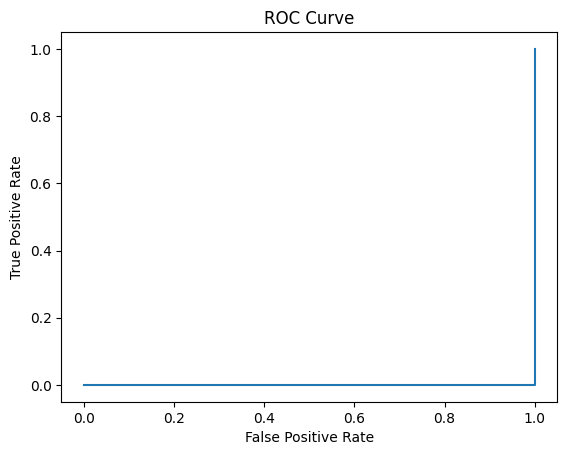

Training set areaUnderROC: 0.0


In [ ]:
# Imprimiendo la curva ROC
import matplotlib.pyplot as plt

trainingSummary = lr_model.summary
lrROC = trainingSummary.roc.toPandas()

plt.plot(lrROC['FPR'], lrROC['TPR'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [ ]:
# Se calculan los verdaderos positivos y falsos, tanto positivos como negativos
tp = predictions.filter((predictions['label'] == 1) & (predictions['prediction'] == 1)).count()
fp = predictions.filter((predictions['label'] == 0) & (predictions['prediction'] == 1)).count()
tn = predictions.filter((predictions['label'] == 0) & (predictions['prediction'] == 0)).count()
fn = predictions.filter((predictions['label'] == 1) & (predictions['prediction'] == 0)).count()

# Accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)
print(f"Accuracy: {accuracy}")

# Precision
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
print(f"Precision: {precision}")

# Recall
recall = tp / (tp + fn) if (tp + fn) != 0 else 0.0
print(f"Recall: {recall}")

# F1 measure
f1_measure = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0.0
print(f"F1 Measure: {f1_measure}")

Accuracy: 1.0
Precision: 0
Recall: 0.0
F1 Measure: 0.0


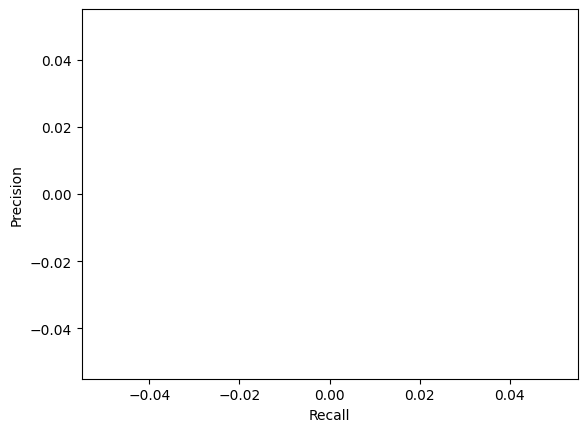

In [ ]:
# Imprimiendo la curva entre Precision y Recall
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'], pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()